# 情感分析：使用卷积神经网络
:label:`sec_sentiment_cnn`

在 :numref:`chap_cnn`中，我们探讨了使用二维卷积神经网络处理二维图像数据的机制，并将其应用于局部特征，如相邻像素。虽然卷积神经网络最初是为计算机视觉设计的，但它也被广泛用于自然语言处理。简单地说，只要将任何文本序列想象成一维图像即可。通过这种方式，一维卷积神经网络可以处理文本中的局部特征，例如$n$元语法。

本节将使用*textCNN*模型来演示如何设计一个表示单个文本 :cite:`Kim.2014`的卷积神经网络架构。与 :numref:`fig_nlp-map-sa-rnn`中使用带有GloVe预训练的循环神经网络架构进行情感分析相比， :numref:`fig_nlp-map-sa-cnn`中唯一的区别在于架构的选择。

![将GloVe放入卷积神经网络架构进行情感分析](../img/nlp-map-sa-cnn.svg)
:label:`fig_nlp-map-sa-cnn`


In [1]:
import os
import torch
import requests
import zipfile
import tarfile
import hashlib
from io import BytesIO

#@save
DATA_HUB = {}
DATA_HUB['aclImdb'] = (
    'http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz',
    '01ada507287d82875905620988597833ad4e0903')

def download(name, cache_dir=os.path.join('..', 'data')):  #@save
    """下载一个DATA_HUB中的文件，返回本地文件名"""
    assert name in DATA_HUB, f"{name} 不存在于 {DATA_HUB}"
    url, sha1_hash = DATA_HUB[name]
    os.makedirs(cache_dir, exist_ok=True)
    fname = os.path.join(cache_dir, url.split('/')[-1])
    if os.path.exists(fname):
        sha1 = hashlib.sha1()
        with open(fname, 'rb') as f:
            while True:
                data = f.read(1048576)
                if not data:
                    break
                sha1.update(data)
        if sha1.hexdigest() == sha1_hash:
            return fname  # 命中缓存
    print(f'正在从{url}下载{fname}...')
    r = requests.get(url, stream=True, verify=True)
    with open(fname, 'wb') as f:
        f.write(r.content)
    return fname

def download_extract(name, folder=None):  #@save
    """下载并解压zip/tar文件"""
    fname = download(name)
    base_dir = os.path.dirname(fname)
    data_dir, ext = os.path.splitext(fname)
    if ext == '.zip':
        fp = zipfile.ZipFile(fname, 'r')
    elif ext in ('.tar', '.gz'):
        fp = tarfile.open(fname, 'r')
    else:
        assert False, '只有zip/tar文件可以被解压缩'
    fp.extractall(base_dir)
    return os.path.join(base_dir, folder) if folder else data_dir

def read_imdb(data_dir, is_train):
    """读取IMDb评论数据集文本序列和标签"""
    data, labels = [], []
    for label in ('pos', 'neg'):
        folder_name = os.path.join(data_dir, 'train' if is_train else 'test',
                                   label)
        for file in os.listdir(folder_name):
            with open(os.path.join(folder_name, file), 'rb') as f:
                review = f.read().decode('utf-8').replace('\n', '')
                data.append(review)
                labels.append(1 if label == 'pos' else 0)
    return data, labels

def tokenize(lines, token='word'):  #@save
    """将文本行拆分为单词或字符词元"""
    if token == 'word':
        return [line.split() for line in lines]
    elif token == 'char':
        return [list(line) for line in lines]
    else:
        print('错误：未知词元类型：' + token)

import collections
import torch

class Vocab:  #@save
    """文本词表"""
    def __init__(self, tokens=None, min_freq=0, reserved_tokens=None):
        if tokens is None:
            tokens = []
        if reserved_tokens is None:
            reserved_tokens = []
        # 按出现频率排序
        counter = count_corpus(tokens)
        self._token_freqs = sorted(counter.items(), key=lambda x: x[1],
                                   reverse=True)
        # 未知词元的索引为0
        self.idx_to_token = ['<unk>'] + reserved_tokens
        self.token_to_idx = {token: idx
                             for idx, token in enumerate(self.idx_to_token)}
        for token, freq in self._token_freqs:
            if freq < min_freq:
                break
            if token not in self.token_to_idx:
                self.idx_to_token.append(token)
                self.token_to_idx[token] = len(self.idx_to_token) - 1

    def __len__(self):
        return len(self.idx_to_token)

    def __getitem__(self, tokens):
        if not isinstance(tokens, (list, tuple)):
            return self.token_to_idx.get(tokens, self.unk)
        return [self.__getitem__(token) for token in tokens]

    def to_tokens(self, indices):
        if not isinstance(indices, (list, tuple)):
            return self.idx_to_token[indices]
        return [self.idx_to_token[index] for index in indices]

    @property
    def unk(self):  # 未知词元的索引为0
        return 0

    @property
    def token_freqs(self):
        return self._token_freqs
    
def count_corpus(tokens):  #@save
    """统计词元的频率"""
    # 这里的tokens是1D列表或2D列表
    if len(tokens) == 0 or isinstance(tokens[0], list):
        # 将词元列表展平成一个列表
        tokens = [token for line in tokens for token in line]
    return collections.Counter(tokens)

def truncate_pad(line, num_steps, padding_token):
    """截断或填充文本序列"""
    if len(line) > num_steps:
        return line[:num_steps]  # 截断
    return line + [padding_token] * (num_steps - len(line))  # 填充

from torch.utils import data

def load_array(data_arrays, batch_size, is_train=True):  #@save
    """构造一个PyTorch数据迭代器"""
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size, shuffle=is_train)

def load_data_imdb(batch_size, num_steps=500):
    """返回数据迭代器和IMDb评论数据集的词表"""
    data_dir = download_extract('aclImdb', 'aclImdb')
    train_data = read_imdb(data_dir, True)
    test_data = read_imdb(data_dir, False)
    train_tokens = tokenize(train_data[0], token='word')
    test_tokens = tokenize(test_data[0], token='word')
    vocab = Vocab(train_tokens, min_freq=5)
    train_features = torch.tensor([truncate_pad(
        vocab[line], num_steps, vocab['<pad>']) for line in train_tokens])
    test_features = torch.tensor([truncate_pad(
        vocab[line], num_steps, vocab['<pad>']) for line in test_tokens])
    train_iter = load_array((train_features, torch.tensor(train_data[1])),
                                batch_size)
    test_iter = load_array((test_features, torch.tensor(test_data[1])),
                               batch_size,
                               is_train=False)
    return train_iter, test_iter, vocab

In [2]:
import torch
from torch import nn
# from d2l import torch as d2l

batch_size = 64
train_iter, test_iter, vocab = load_data_imdb(batch_size)

## 一维卷积

在介绍该模型之前，让我们先看看一维卷积是如何工作的。请记住，这只是基于互相关运算的二维卷积的特例。

![一维互相关运算。阴影部分是第一个输出元素以及用于输出计算的输入和核张量元素：$0\times1+1\times2=2$](../img/conv1d.svg)
:label:`fig_conv1d`

如 :numref:`fig_conv1d`中所示，在一维情况下，卷积窗口在输入张量上从左向右滑动。在滑动期间，卷积窗口中某个位置包含的输入子张量（例如， :numref:`fig_conv1d`中的$0$和$1$）和核张量（例如， :numref:`fig_conv1d`中的$1$和$2$）按元素相乘。这些乘法的总和在输出张量的相应位置给出单个标量值（例如， :numref:`fig_conv1d`中的$0\times1+1\times2=2$）。

我们在下面的`corr1d`函数中实现了一维互相关。给定输入张量`X`和核张量`K`，它返回输出张量`Y`。


In [3]:
def corr1d(X, K):
    w = K.shape[0]
    Y = torch.zeros((X.shape[0] - w + 1))
    for i in range(Y.shape[0]):
        Y[i] = (X[i: i + w] * K).sum()
    return Y

我们可以从 :numref:`fig_conv1d`构造输入张量`X`和核张量`K`来验证上述一维互相关实现的输出。


In [4]:
X, K = torch.tensor([0, 1, 2, 3, 4, 5, 6]), torch.tensor([1, 2])
corr1d(X, K)

tensor([ 2.,  5.,  8., 11., 14., 17.])

对于任何具有多个通道的一维输入，卷积核需要具有相同数量的输入通道。然后，对于每个通道，对输入的一维张量和卷积核的一维张量执行互相关运算，将所有通道上的结果相加以产生一维输出张量。 :numref:`fig_conv1d_channel`演示了具有3个输入通道的一维互相关操作。

![具有3个输入通道的一维互相关运算。阴影部分是第一个输出元素以及用于输出计算的输入和核张量元素：$2\times(-1)+3\times(-3)+1\times3+2\times4+0\times1+1\times2=2$](../img/conv1d-channel.svg)
:label:`fig_conv1d_channel`

我们可以实现多个输入通道的一维互相关运算，并在 :numref:`fig_conv1d_channel`中验证结果。


In [5]:
def corr1d_multi_in(X, K):
    # 首先，遍历'X'和'K'的第0维（通道维）。然后，把它们加在一起
    return sum(corr1d(x, k) for x, k in zip(X, K))

X = torch.tensor([[0, 1, 2, 3, 4, 5, 6],
              [1, 2, 3, 4, 5, 6, 7],
              [2, 3, 4, 5, 6, 7, 8]])
K = torch.tensor([[1, 2], [3, 4], [-1, -3]])
corr1d_multi_in(X, K)

tensor([ 2.,  8., 14., 20., 26., 32.])

注意，多输入通道的一维互相关等同于单输入通道的二维互相关。举例说明， :numref:`fig_conv1d_channel`中的多输入通道一维互相关的等价形式是 :numref:`fig_conv1d_2d`中的单输入通道二维互相关，其中卷积核的高度必须与输入张量的高度相同。

![具有单个输入通道的二维互相关操作。阴影部分是第一个输出元素以及用于输出计算的输入和内核张量元素： $2\times(-1)+3\times(-3)+1\times3+2\times4+0\times1+1\times2=2$](../img/conv1d-2d.svg)
:label:`fig_conv1d_2d`

 :numref:`fig_conv1d`和 :numref:`fig_conv1d_channel`中的输出都只有一个通道。与 :numref:`subsec_multi-output-channels`中描述的具有多个输出通道的二维卷积相同，我们也可以为一维卷积指定多个输出通道。

## 最大时间汇聚层

类似地，我们可以使用汇聚层从序列表示中提取最大值，作为跨时间步的最重要特征。textCNN中使用的*最大时间汇聚层*的工作原理类似于一维全局汇聚 :cite:`Collobert.Weston.Bottou.ea.2011`。对于每个通道在不同时间步存储值的多通道输入，每个通道的输出是该通道的最大值。请注意，最大时间汇聚允许在不同通道上使用不同数量的时间步。

## textCNN模型

使用一维卷积和最大时间汇聚，textCNN模型将单个预训练的词元表示作为输入，然后获得并转换用于下游应用的序列表示。

对于具有由$d$维向量表示的$n$个词元的单个文本序列，输入张量的宽度、高度和通道数分别为$n$、$1$和$d$。textCNN模型将输入转换为输出，如下所示：

1. 定义多个一维卷积核，并分别对输入执行卷积运算。具有不同宽度的卷积核可以捕获不同数目的相邻词元之间的局部特征。
1. 在所有输出通道上执行最大时间汇聚层，然后将所有标量汇聚输出连结为向量。
1. 使用全连接层将连结后的向量转换为输出类别。Dropout可以用来减少过拟合。

![textCNN的模型架构](../img/textcnn.svg)
:label:`fig_conv1d_textcnn`

 :numref:`fig_conv1d_textcnn`通过一个具体的例子说明了textCNN的模型架构。输入是具有11个词元的句子，其中每个词元由6维向量表示。因此，我们有一个宽度为11的6通道输入。定义两个宽度为2和4的一维卷积核，分别具有4个和5个输出通道。它们产生4个宽度为$11-2+1=10$的输出通道和5个宽度为$11-4+1=8$的输出通道。尽管这9个通道的宽度不同，但最大时间汇聚层给出了一个连结的9维向量，该向量最终被转换为用于二元情感预测的2维输出向量。

### 定义模型

我们在下面的类中实现textCNN模型。与 :numref:`sec_sentiment_rnn`的双向循环神经网络模型相比，除了用卷积层代替循环神经网络层外，我们还使用了两个嵌入层：一个是可训练权重，另一个是固定权重。


In [6]:
class TextCNN(nn.Module):
    def __init__(self, vocab_size, embed_size, kernel_sizes, num_channels,
                 **kwargs):
        super(TextCNN, self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        # 这个嵌入层不需要训练
        self.constant_embedding = nn.Embedding(vocab_size, embed_size)
        self.dropout = nn.Dropout(0.5)
        self.decoder = nn.Linear(sum(num_channels), 2)
        # 最大时间汇聚层没有参数，因此可以共享此实例
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.relu = nn.ReLU()
        # 创建多个一维卷积层
        self.convs = nn.ModuleList()
        for c, k in zip(num_channels, kernel_sizes):
            self.convs.append(nn.Conv1d(2 * embed_size, c, k))

    def forward(self, inputs):
        # 沿着向量维度将两个嵌入层连结起来，
        # 每个嵌入层的输出形状都是（批量大小，词元数量，词元向量维度）连结起来
        embeddings = torch.cat((
            self.embedding(inputs), self.constant_embedding(inputs)), dim=2)
        # 根据一维卷积层的输入格式，重新排列张量，以便通道作为第2维
        embeddings = embeddings.permute(0, 2, 1)
        # 每个一维卷积层在最大时间汇聚层合并后，获得的张量形状是（批量大小，通道数，1）
        # 删除最后一个维度并沿通道维度连结
        encoding = torch.cat([
            torch.squeeze(self.relu(self.pool(conv(embeddings))), dim=-1)
            for conv in self.convs], dim=1)
        outputs = self.decoder(self.dropout(encoding))
        return outputs

让我们创建一个textCNN实例。它有3个卷积层，卷积核宽度分别为3、4和5，均有100个输出通道。


In [7]:
def try_all_gpus():  #@save
    """返回所有可用的GPU，如果没有GPU，则返回[cpu(),]"""
    devices = [torch.device(f'cuda:{i}')
             for i in range(torch.cuda.device_count())]
    return devices if devices else [torch.device('cpu')]

In [8]:
embed_size, kernel_sizes, nums_channels = 100, [3, 4, 5], [100, 100, 100]
devices = try_all_gpus()
net = TextCNN(len(vocab), embed_size, kernel_sizes, nums_channels)

def init_weights(m):
    if type(m) in (nn.Linear, nn.Conv1d):
        nn.init.xavier_uniform_(m.weight)

net.apply(init_weights);

### 加载预训练词向量

与 :numref:`sec_sentiment_rnn`相同，我们加载预训练的100维GloVe嵌入作为初始化的词元表示。这些词元表示（嵌入权重）在`embedding`中将被训练，在`constant_embedding`中将被固定。


In [9]:
#@save
class TokenEmbedding:
    """GloVe嵌入"""
    def __init__(self, embedding_name):
        self.idx_to_token, self.idx_to_vec = self._load_embedding(
            embedding_name)
        self.unknown_idx = 0
        self.token_to_idx = {token: idx for idx, token in
                             enumerate(self.idx_to_token)}

    def _load_embedding(self, embedding_name):
        idx_to_token, idx_to_vec = ['<unk>'], []
        data_dir = download_extract(embedding_name)
        # GloVe网站：https://nlp.stanford.edu/projects/glove/
        # fastText网站：https://fasttext.cc/
        with open(os.path.join(data_dir, 'vec.txt'), 'r') as f:
            for line in f:
                elems = line.rstrip().split(' ')
                token, elems = elems[0], [float(elem) for elem in elems[1:]]
                # 跳过标题信息，例如fastText中的首行
                if len(elems) > 1:
                    idx_to_token.append(token)
                    idx_to_vec.append(elems)
        idx_to_vec = [[0] * len(idx_to_vec[0])] + idx_to_vec
        return idx_to_token, torch.tensor(idx_to_vec)

    def __getitem__(self, tokens):
        indices = [self.token_to_idx.get(token, self.unknown_idx)
                   for token in tokens]
        vecs = self.idx_to_vec[torch.tensor(indices)]
        return vecs

    def __len__(self):
        return len(self.idx_to_token)

In [11]:
DATA_HUB = {}
DATA_URL = 'http://d2l-data.s3-accelerate.amazonaws.com/'

#@save
DATA_HUB['glove.6b.100d'] = (DATA_URL + 'glove.6B.100d.zip',
                                 'cd43bfb07e44e6f27cbcc7bc9ae3d80284fdaf5a')

glove_embedding = TokenEmbedding('glove.6b.100d')
embeds = glove_embedding[vocab.idx_to_token]
net.embedding.weight.data.copy_(embeds)
net.constant_embedding.weight.data.copy_(embeds)
net.constant_embedding.weight.requires_grad = False

### 训练和评估模型

现在我们可以训练textCNN模型进行情感分析。


In [12]:
def try_all_gpus():  #@save
    """返回所有可用的GPU，如果没有GPU，则返回[cpu(),]"""
    devices = [torch.device(f'cuda:{i}')
             for i in range(torch.cuda.device_count())]
    return devices if devices else [torch.device('cpu')]

import time
import numpy as np

class Timer:  #@save
    """记录多次运行时间"""
    def __init__(self):
        self.times = []
        self.start()

    def start(self):
        """启动计时器"""
        self.tik = time.time()

    def stop(self):
        """停止计时器并将时间记录在列表中"""
        self.times.append(time.time() - self.tik)
        return self.times[-1]

    def avg(self):
        """返回平均时间"""
        return sum(self.times) / len(self.times)

    def sum(self):
        """返回时间总和"""
        return sum(self.times)

    def cumsum(self):
        """返回累计时间"""
        return np.array(self.times).cumsum().tolist()

from IPython import display

class Animator:  #@save
    """在动画中绘制数据"""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        # 增量地绘制多条线
        if legend is None:
            legend = []
        
        # 替换 d2l.use_svg_display()
        import matplotlib.pyplot as plt
        plt.rcParams['figure.figsize'] = figsize
        self.fig, self.axes = plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # 替换 d2l.set_axes，使用 lambda 函数直接配置参数
        self.config_axes = lambda: self._set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def _set_axes(self, ax, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
        """设置坐标轴标签、范围和比例"""
        import matplotlib.pyplot as plt
        # 设置坐标轴标签
        if xlabel:
            ax.set_xlabel(xlabel)
        if ylabel:
            ax.set_ylabel(ylabel)
        # 设置坐标轴范围
        if xlim:
            ax.set_xlim(xlim)
        if ylim:
            ax.set_ylim(ylim)
        # 设置坐标轴比例
        if xscale:
            ax.set_xscale(xscale)
        if yscale:
            ax.set_yscale(yscale)
        # 设置图例
        if legend:
            ax.legend(legend)
        # 添加网格
        ax.grid(True)

    def add(self, x, y):
        # 向图表中添加多个数据点
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

class Accumulator:  #@save
    """在n个变量上累加"""
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

def accuracy(y_hat, y):  #@save
    """计算预测正确的数量"""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())

def train_batch_ch13(net, X, y, loss, trainer, devices):
    """用多GPU进行小批量训练"""
    if isinstance(X, list):
        # 微调BERT中所需
        X = [x.to(devices[0]) for x in X]
    else:
        X = X.to(devices[0])
    y = y.to(devices[0])
    net.train()
    trainer.zero_grad()
    pred = net(X)
    l = loss(pred, y)
    l.sum().backward()
    trainer.step()
    train_loss_sum = l.sum()
    train_acc_sum = accuracy(pred, y)
    return train_loss_sum, train_acc_sum

def evaluate_accuracy_gpu(net, data_iter, device=None): #@save
    """使用GPU计算模型在数据集上的精度"""
    if isinstance(net, nn.Module):
        net.eval()  # 设置为评估模式
        if not device:
            device = next(iter(net.parameters())).device
    # 正确预测的数量，总预测的数量
    metric = Accumulator(2)
    with torch.no_grad():
        for X, y in data_iter:
            if isinstance(X, list):
                # BERT微调所需的（之后将介绍）
                X = [x.to(device) for x in X]
            else:
                X = X.to(device)
            y = y.to(device)
            metric.add(accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

#@save
def train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs,
               devices=try_all_gpus()):
    """用多GPU进行模型训练"""
    timer, num_batches = Timer(), len(train_iter)
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0, 1],
                            legend=['train loss', 'train acc', 'test acc'])
    net = nn.DataParallel(net, device_ids=devices).to(devices[0])
    for epoch in range(num_epochs):
        # 4个维度：储存训练损失，训练准确度，实例数，特点数
        metric = Accumulator(4)
        for i, (features, labels) in enumerate(train_iter):
            timer.start()
            l, acc = train_batch_ch13(
                net, features, labels, loss, trainer, devices)
            metric.add(l, acc, labels.shape[0], labels.numel())
            timer.stop()
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (metric[0] / metric[2], metric[1] / metric[3],
                              None))
        test_acc = evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {metric[0] / metric[2]:.3f}, train acc '
          f'{metric[1] / metric[3]:.3f}, test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec on '
          f'{str(devices)}')

loss 0.063, train acc 0.980, test acc 0.876
233.3 examples/sec on [device(type='cpu')]


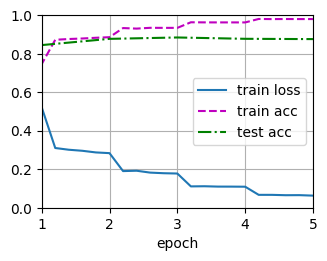

In [13]:
lr, num_epochs = 0.001, 5
trainer = torch.optim.Adam(net.parameters(), lr=lr)
loss = nn.CrossEntropyLoss(reduction="none")
train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, devices)

下面，我们使用训练好的模型来预测两个简单句子的情感。


In [14]:
def try_gpu(i=0):  #@save
    """如果存在，则返回gpu(i)，否则返回cpu()"""
    if torch.cuda.device_count() >= i + 1:
        return torch.device(f'cuda:{i}')
    return torch.device('cpu')

def predict_sentiment(net, vocab, sequence):
    """预测文本序列的情感"""
    sequence = torch.tensor(vocab[sequence.split()], device=try_gpu())
    label = torch.argmax(net(sequence.reshape(1, -1)), dim=1)
    return 'positive' if label == 1 else 'negative'

In [15]:
predict_sentiment(net, vocab, 'this movie is so great')

'positive'

In [16]:
predict_sentiment(net, vocab, 'this movie is so bad')

'negative'

## 小结

* 一维卷积神经网络可以处理文本中的局部特征，例如$n$元语法。
* 多输入通道的一维互相关等价于单输入通道的二维互相关。
* 最大时间汇聚层允许在不同通道上使用不同数量的时间步长。
* textCNN模型使用一维卷积层和最大时间汇聚层将单个词元表示转换为下游应用输出。

## 练习

1. 调整超参数，并比较 :numref:`sec_sentiment_rnn`中用于情感分析的架构和本节中用于情感分析的架构，例如在分类精度和计算效率方面。
1. 请试着用 :numref:`sec_sentiment_rnn`练习中介绍的方法进一步提高模型的分类精度。
1. 在输入表示中添加位置编码。它是否提高了分类的精度？


[Discussions](https://discuss.d2l.ai/t/5720)
